# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [67]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from collections import Counter
# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [68]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep ='delimiter',delimiter = ';', engine = 'python')

In [69]:
# Checking for general population
print(azdias.shape)
azdias.head()

(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [70]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [71]:
# Identify missing or unknown data values and convert them to NaNs.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep ='delimiter',delimiter = ';', engine = 'python')
feat_info.missing_or_unknown = feat_info['missing_or_unknown'].apply(lambda x: x.strip('[]').split(','))

In [72]:
def NAFunc(x, miss_unknown_list):
    x_output = x
    for i in miss_unknown_list:
        try:
            miss_unknown_value = float(i)
        except ValueError:
            miss_unknown_value = i
        if x == miss_unknown_value:
            x_output = np.nan
            break
    return x_output

for cols in azdias.columns.tolist():
    NAList = feat_info[feat_info.attribute == cols]['missing_or_unknown'].values[0]
    azdias[cols] = azdias[cols].apply(lambda x: NAFunc(x, NAList))

In [73]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [74]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
print(azdias.info())
pd.set_option('display.max_rows', None)
percent_missing = pd.DataFrame(((azdias.isnull() | azdias.isna()).sum() * 100 / azdias.index.size).round(2).sort_values(ascending=False))
print(percent_missing.drop(percent_missing[percent_missing.iloc[:,0]>40].index.values))
print(percent_missing)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

<Container object of 85 artists>

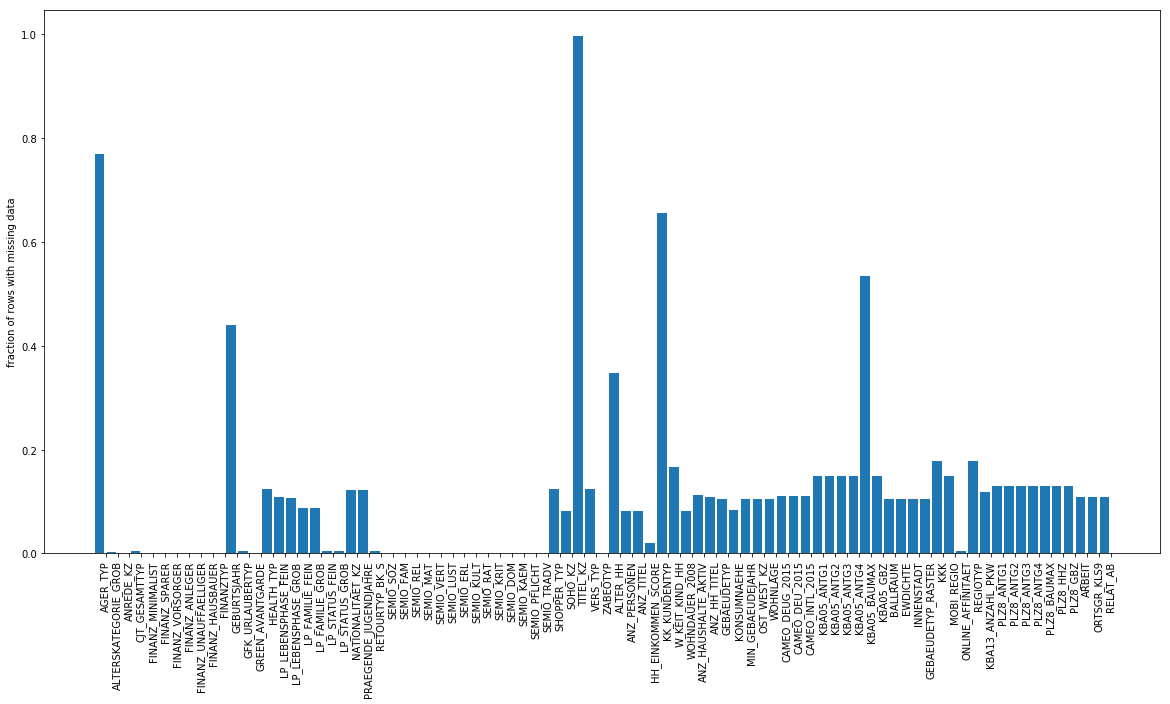

In [75]:
# Investigate patterns in the amount of missing data in each column.
null_counts = azdias.isnull().sum()/len(azdias)
plt.figure(figsize=(20,10))
plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
plt.ylabel('fraction of rows with missing data')
plt.bar(np.arange(len(null_counts)),null_counts)

In [76]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

**Answer**:

The columns that I have decided to remove are the ones that have more than or close to 50% of data points missing. From the percentage chart on each column and verifying it with the histogram of missing values that is drawn, the top 5 candidates to be dropped before moving further with our analysis are:

1.) TITEL_KZ                 99.76% missing values

2,) AGER_TYP                 76.96% missing values

3.) KK_KUNDENTYP             65.60% missing values

4.) KBA05_BAUMAX             53.47% missing values

5.) GEBURTSJAHR              44.02% missing values

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. Make sure you report your observations in the discussion section. **Either way, you should continue your analysis below using just the subset of the data with few or no missing values.**

In [77]:
# How much data is missing in each row of the dataset?
#azdias.isnull().sum(axis=1).sort_values(ascending=False)

In [78]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
AboveThresholdMissing_df = azdias[azdias.isnull().sum(axis=1) > 30]
print(AboveThresholdMissing_df.shape)
BelowThresholdMissing_df = azdias[azdias.isnull().sum(axis=1) <= 30]
print(BelowThresholdMissing_df.shape)

(93240, 85)
(797981, 85)


In [79]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
print(((AboveThresholdMissing_df.isnull() | AboveThresholdMissing_df.isna()).sum() * 100 / AboveThresholdMissing_df.index.size).round(2).sort_values().head())
print(((BelowThresholdMissing_df.isnull() | BelowThresholdMissing_df.isna()).sum() * 100 / BelowThresholdMissing_df.index.size).round(2).sort_values().head(20))

ZABEOTYP         0.0
SEMIO_TRADV      0.0
SEMIO_PFLICHT    0.0
SEMIO_KAEM       0.0
SEMIO_DOM        0.0
dtype: float64
ZABEOTYP              0.0
HH_EINKOMMEN_SCORE    0.0
SEMIO_SOZ             0.0
SEMIO_FAM             0.0
SEMIO_REL             0.0
SEMIO_MAT             0.0
SEMIO_VERT            0.0
SEMIO_LUST            0.0
SEMIO_ERL             0.0
SEMIO_KULT            0.0
SEMIO_RAT             0.0
SEMIO_KRIT            0.0
SEMIO_DOM             0.0
SEMIO_KAEM            0.0
SEMIO_PFLICHT         0.0
SEMIO_TRADV           0.0
ANZ_TITEL             0.0
SOHO_KZ               0.0
WOHNDAUER_2008        0.0
ANZ_PERSONEN          0.0
dtype: float64


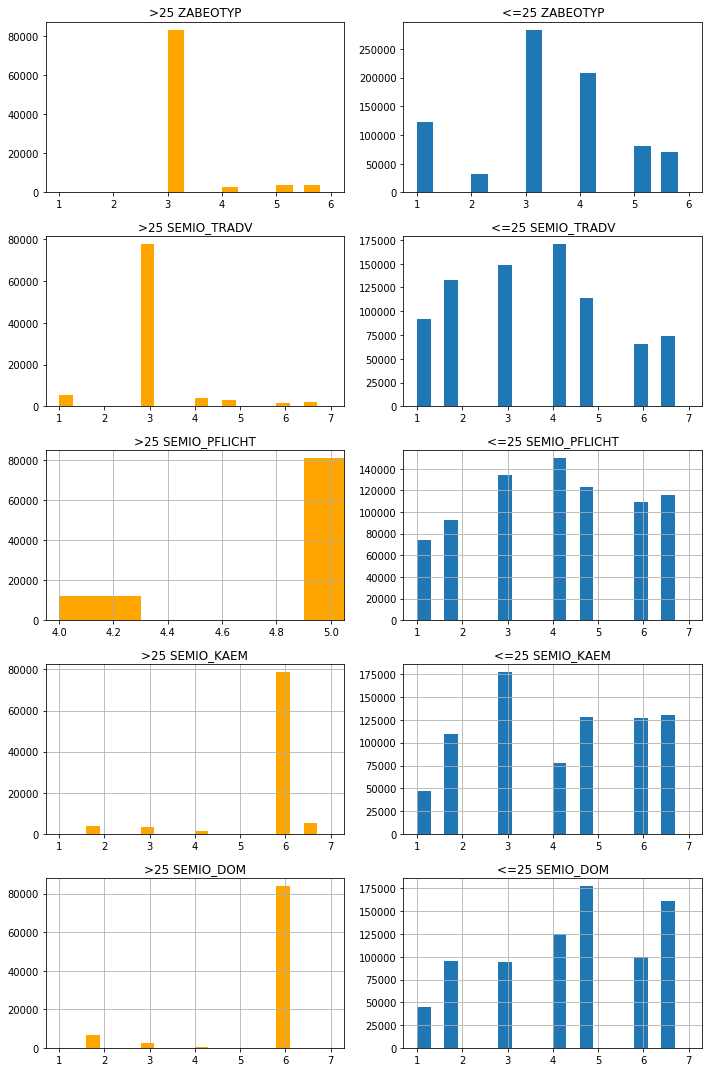

In [80]:
# Column distributions for above threshold
figure(figsize=(10,15))

plt.subplot(5, 2, 1)
plt.hist(AboveThresholdMissing_df['ZABEOTYP'],color = 'orange', width = 0.3)
plt.title('>25 ZABEOTYP')
plt.subplot(5, 2, 2)
plt.hist(BelowThresholdMissing_df['ZABEOTYP'], width = 0.3)
plt.title('<=25 ZABEOTYP')
plt.tight_layout()

plt.subplot(5, 2, 3)
plt.hist(AboveThresholdMissing_df['SEMIO_TRADV'],color = 'orange', width = 0.3)
plt.title('>25 SEMIO_TRADV')
plt.subplot(5, 2, 4)
plt.hist(BelowThresholdMissing_df['SEMIO_TRADV'], width = 0.3)
plt.title('<=25 SEMIO_TRADV')
plt.tight_layout()

plt.subplot(5, 2, 5)
AboveThresholdMissing_df['SEMIO_PFLICHT'].hist(color = 'orange', width = 0.3)
plt.title('>25 SEMIO_PFLICHT')
plt.subplot(5, 2, 6)
BelowThresholdMissing_df['SEMIO_PFLICHT'].hist( width = 0.3)
plt.title('<=25 SEMIO_PFLICHT')
plt.tight_layout()

plt.subplot(5, 2, 7)
AboveThresholdMissing_df['SEMIO_KAEM'].hist(color = 'orange', width = 0.3)
plt.title('>25 SEMIO_KAEM')
plt.subplot(5, 2, 8)
BelowThresholdMissing_df['SEMIO_KAEM'].hist( width = 0.3)
plt.title('<=25 SEMIO_KAEM')
plt.tight_layout()

plt.subplot(5, 2, 9)
AboveThresholdMissing_df['SEMIO_DOM'].hist(color = 'orange', width = 0.3)
plt.title('>25 SEMIO_DOM')
plt.subplot(5, 2, 10)
BelowThresholdMissing_df['SEMIO_DOM'].hist( width = 0.3)
plt.title('<=25 SEMIO_DOM')
plt.tight_layout()

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

**Answer**

Outliers:

For the purpose of setting a threshold for missing values in row, I have declared it as 30. The reason behind this number is that we have 85 total columns and missing values must not be more than 35%. The place I work has made this standard after their heavy research on marketing data from various surveys. Hence as this is an unsupervised learning, I decided to keep threshold of 35% which comes to approximately 30.

Distribution:

We can clearly see that the columns which has more than 30 NaN values in a row (and we know that highest number of missing NaNs in a row is 54) foes not contain  any information as such since we cannot draw a detailed distribution of the column just like in case of values plotted for same column on right side where it shows very clear flow of wave of distribution. Thus the plots on right side give us a visual understanding to estimate where peak lies in distribution how is it skewed unlike the plot for same column on left side where we do not see anything more than one or two spike and rest chart left as whitespace

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [81]:
# How many features are there of each data type?
print(feat_info.groupby('type')['attribute'].nunique())

# Let us create list of variables belonging to categorical and mixed types
CategoricalVariables = feat_info[feat_info['type']=='categorical']['attribute']
MixedVariables = feat_info[feat_info['type']=='mixed']['attribute']

# Lets print number or length of variables belonging to each of categorical and mixed types after creating list to confirm if our lists are correct.
print(len(CategoricalVariables))
print(len(MixedVariables))

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64
21
7


In [82]:
# Subsetting dataframes for both 'categorical' and 'mixed' types to understand percent of missing values in them
BelowThresholdMissing_df_CategoricalVariables = BelowThresholdMissing_df[CategoricalVariables]
BelowThresholdMissing_df_MixedVariables = BelowThresholdMissing_df[MixedVariables]

print(((BelowThresholdMissing_df_CategoricalVariables.isnull() | BelowThresholdMissing_df_CategoricalVariables.isna()).sum() * 100 / BelowThresholdMissing_df_CategoricalVariables.index.size).round(2).sort_values(ascending=False))
print(((BelowThresholdMissing_df_MixedVariables.isnull() | BelowThresholdMissing_df_MixedVariables.isna()).sum() * 100 / BelowThresholdMissing_df_MixedVariables.index.size).round(2).sort_values(ascending=False))

TITEL_KZ            99.74
AGER_TYP            74.87
KK_KUNDENTYP        62.48
VERS_TYP             4.60
SHOPPER_TYP          4.60
NATIONALITAET_KZ     4.25
LP_FAMILIE_GROB      3.94
LP_FAMILIE_FEIN      3.94
CAMEO_DEUG_2015      0.77
CAMEO_DEU_2015       0.77
LP_STATUS_GROB       0.59
LP_STATUS_FEIN       0.59
GFK_URLAUBERTYP      0.59
CJT_GESAMTTYP        0.59
ZABEOTYP             0.00
GEBAEUDETYP          0.00
SOHO_KZ              0.00
OST_WEST_KZ          0.00
GREEN_AVANTGARDE     0.00
FINANZTYP            0.00
ANREDE_KZ            0.00
dtype: float64
KBA05_BAUMAX             48.03
LP_LEBENSPHASE_FEIN       6.28
LP_LEBENSPHASE_GROB       5.92
PRAEGENDE_JUGENDJAHRE     3.60
PLZ8_BAUMAX               2.92
CAMEO_INTL_2015           0.77
WOHNLAGE                  0.00
dtype: float64


In [83]:
# Now as per previously stated, I am going to drop variables that have values close to 50% or more missing.

azdias_new = azdias.copy() # creating another copy of azdias to prevent manipulations in original
print(azdias_new.shape)
print(azdias.shape)

# Dropping columns from both 'categorical' and 'mixed' types which have close to or more than 50% data missing
BelowThresholdMissing_df.drop(columns=['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR'], inplace=True)
print(BelowThresholdMissing_df.shape)
BelowThresholdMissing_df.head()

(891221, 85)
(891221, 85)
(797981, 80)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [84]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# First glancing the number of categories within each categorical variable
print(BelowThresholdMissing_df_CategoricalVariables.nunique().sort_values())

# Trying to find the binary categorical variable with non-numeric category
print(BelowThresholdMissing_df[['ANREDE_KZ','OST_WEST_KZ','VERS_TYP','SOHO_KZ','GREEN_AVANTGARDE']].head())

# Creating dummies for non-numeric variables
#BelowThresholdMissing_df[['OST_WEST_KZ','NATIONALITAET_KZ','SHOPPER_TYP','LP_FAMILIE_GROB','LP_STATUS_GROB',
#                                'FINANZTYP','ZABEOTYP','CJT_GESAMTTYP','GEBAEUDETYP','CAMEO_DEUG_2015','LP_STATUS_FEIN',
#                               'GFK_URLAUBERTYP','CAMEO_DEU_2015']].head()
BelowThresholdMissing_df.shape

ANREDE_KZ            2
OST_WEST_KZ          2
VERS_TYP             2
SOHO_KZ              2
GREEN_AVANTGARDE     2
AGER_TYP             3
NATIONALITAET_KZ     3
SHOPPER_TYP          4
LP_FAMILIE_GROB      5
LP_STATUS_GROB       5
TITEL_KZ             5
FINANZTYP            6
ZABEOTYP             6
KK_KUNDENTYP         6
CJT_GESAMTTYP        6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
LP_STATUS_FEIN      10
LP_FAMILIE_FEIN     11
GFK_URLAUBERTYP     12
CAMEO_DEU_2015      44
dtype: int64
   ANREDE_KZ OST_WEST_KZ  VERS_TYP  SOHO_KZ  GREEN_AVANTGARDE
1          2           W       2.0      1.0                 0
2          2           W       1.0      0.0                 1
3          2           W       1.0      0.0                 0
4          1           W       2.0      0.0                 0
5          2           W       2.0      0.0                 0


(797981, 80)

The variable that is of binary categories but is non-numeric is **OST_WEST_KZ**

In [85]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Encoding OST_WEST_KZ variable
cat_dum = pd.get_dummies(BelowThresholdMissing_df[['OST_WEST_KZ']])
BelowThresholdMissing_df = pd.concat([BelowThresholdMissing_df, cat_dum], axis = 1)
print(BelowThresholdMissing_df.shape)

# Dropping all the multi-level categorical and original copy of 'OST_WEST_KZ' variables from our analysis
BelowThresholdMissing_df.drop(columns = ['OST_WEST_KZ','NATIONALITAET_KZ','SHOPPER_TYP','LP_FAMILIE_GROB','LP_STATUS_GROB',
                                'FINANZTYP','ZABEOTYP','CJT_GESAMTTYP','GEBAEUDETYP','CAMEO_DEUG_2015','LP_STATUS_FEIN',
                               'GFK_URLAUBERTYP','CAMEO_DEU_2015'], inplace=True)

BelowThresholdMissing_df.shape

(797981, 82)


(797981, 69)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

**Answer**

For simplicity of this project, I valued only the columns that were told to be important and I dropped rest of the columns. Hence I preserved categorical columns with only two categories and dropped all the multi-categorical columns. The OST_WEST_KZ column has been encoded and formatted to numeric.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [86]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
#BelowThresholdMissing_df[['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']].head(5)

# Lets first understand values and their representation from dictionary for given two mixed variables
import markdown
from bs4 import BeautifulSoup
DataDic_df = open('Data_Dictionary.md', 'r')
DataDic_df = markdown.markdown(DataDic_df.read())
print(BeautifulSoup(DataDic_df))

<html><body><h1>Data Dictionary for Identify Customer Segments Data</h1>
<h2>Introduction</h2>
<p>The data for this project consist of two files:</p>
<ul>
<li>Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)</li>
<li>Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)</li>
</ul>
<p>The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.</p>
<h3>Table of Contents</h3>
<ol>
<li>Person-level features</li>
<li>Household-level features</li>
<li>Building-level features

/opt/conda/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /opt/conda/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [87]:
# Let us make copies of the both original mixed variables,'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015'
BelowThresholdMissing_df.loc[:,'PRAEGENDE_JUGENDJAHRE_copy'] = BelowThresholdMissing_df['PRAEGENDE_JUGENDJAHRE']
BelowThresholdMissing_df.loc[:,'CAMEO_INTL_2015_copy'] = BelowThresholdMissing_df['CAMEO_INTL_2015']

BelowThresholdMissing_df[['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015']].head()

,PRAEGENDE_JUGENDJAHRE,CAMEO_INTL_2015
1,14.0,51
2,15.0,24
3,8.0,12
4,8.0,43
5,3.0,54


In [88]:
# Investigate "PRAEGENDE_JUGENDJAHRE","CAMEO_INTL_2015" and engineer two new variables.

# Operating on 'PRAEGENDE_JUGENDJAHRE'
# Assigning 'interval decades' to PRAEGENDE_JUGENDJAHRE_IntervalDecade
PRAEGENDE_JUGENDJAHRE_IntervalDecade = {1.0:40, 2.0:40, 
                                        3.0:50, 4.0:50, 
                                        5.0:60, 6.0:60, 7.0:60, 
                                        8.0:70, 9.0:70, 
                                        10.0:80, 11.0:80, 12.0:80, 13.0:80, 
                                        14.0:90, 15.0: 90}
BelowThresholdMissing_df['PRAEGENDE_JUGENDJAHRE_IntervalDecade'] = BelowThresholdMissing_df[
    'PRAEGENDE_JUGENDJAHRE'].map(PRAEGENDE_JUGENDJAHRE_IntervalDecade).fillna(BelowThresholdMissing_df[
    'PRAEGENDE_JUGENDJAHRE'])

# Assigning 'Movements' as 1 to Mainstream and 0 t0 Avantgarde
PRAEGENDE_JUGENDJAHRE_Movement = {1.0:1, 3.0:1, 5.0:1, 8.0:1, 10.0:1, 12.0:1, 14.0:1,
                                  2.0:0, 4.0:0, 6.0:0, 7.0:0, 9.0:0, 11.0:0, 13.0:0, 15.0:0} 

BelowThresholdMissing_df['PRAEGENDE_JUGENDJAHRE_Movement'] = BelowThresholdMissing_df[
    'PRAEGENDE_JUGENDJAHRE_copy'].map(PRAEGENDE_JUGENDJAHRE_Movement).fillna(BelowThresholdMissing_df[
    'PRAEGENDE_JUGENDJAHRE_copy'])

print(BelowThresholdMissing_df[['PRAEGENDE_JUGENDJAHRE_IntervalDecade','PRAEGENDE_JUGENDJAHRE_copy',
                                'PRAEGENDE_JUGENDJAHRE_Movement','PRAEGENDE_JUGENDJAHRE']].head(10))

    PRAEGENDE_JUGENDJAHRE_IntervalDecade  PRAEGENDE_JUGENDJAHRE_copy  \
1                                   90.0                        14.0   
2                                   90.0                        15.0   
3                                   70.0                         8.0   
4                                   70.0                         8.0   
5                                   50.0                         3.0   
6                                   80.0                        10.0   
7                                   70.0                         8.0   
8                                   80.0                        11.0   
9                                   90.0                        15.0   
10                                  50.0                         3.0   

    PRAEGENDE_JUGENDJAHRE_Movement  PRAEGENDE_JUGENDJAHRE  
1                              1.0                   14.0  
2                              0.0                   15.0  
3                          

In [89]:
# Operating on 'CAMEO_INTL_2015'

# COnverting 'CAMEO_INTL_2015' to string for ease of split of double digit numbers
BelowThresholdMissing_df['CAMEO_INTL_2015_str_copy'] = BelowThresholdMissing_df['CAMEO_INTL_2015'].astype(str)

# Splitting the digits and putting them in new two columns
BelowThresholdMissing_df['CAMEO_INTL_2015_WealthTenses'] = BelowThresholdMissing_df['CAMEO_INTL_2015'].str[0]
BelowThresholdMissing_df['CAMEO_INTL_2015_LifeOneses'] = BelowThresholdMissing_df['CAMEO_INTL_2015'].str[1]

# Converting bavk both the newly generate columns to float
BelowThresholdMissing_df['CAMEO_INTL_2015_LifeOneses'] = BelowThresholdMissing_df['CAMEO_INTL_2015_LifeOneses'].astype(float)
BelowThresholdMissing_df['CAMEO_INTL_2015_WealthTenses'] = BelowThresholdMissing_df['CAMEO_INTL_2015_WealthTenses'].astype(float)

# COnfirming if conversion to float is successful and original data type is preserved
print(BelowThresholdMissing_df['CAMEO_INTL_2015_WealthTenses'].dtypes)
print(BelowThresholdMissing_df['CAMEO_INTL_2015_LifeOneses'].dtypes)

# Glancing the values of 'CAMEO_INTL_2015' after manipulation
BelowThresholdMissing_df[['CAMEO_INTL_2015_WealthTenses','CAMEO_INTL_2015_LifeOneses', 
                         'CAMEO_INTL_2015_str_copy', 'CAMEO_INTL_2015']].head()

float64
float64


,CAMEO_INTL_2015_WealthTenses,CAMEO_INTL_2015_LifeOneses,CAMEO_INTL_2015_str_copy,CAMEO_INTL_2015
1,5.0,1.0,51,51
2,2.0,4.0,24,24
3,1.0,2.0,12,12
4,4.0,3.0,43,43
5,5.0,4.0,54,54


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

**Answer**

Similar to the categorical column selection approach, I have dropped all columns of mixed type and preserved only the two that were asked me to give importance to. Hence I have encoded 'CAMEO_INTL_2015' and as per wealth and life types by splitting the column tense's and ones's digits respectively into columns named as 'CAMEO_INTL_2015_WealthTenses' and 'CAMEO_INTL_2015_LifeOneses' which are shown above.

PRAEGENDE_JUGENDJAHRE has also been split into interval decade and movement pattern as two columns. I have named the two newly generated columns as 'PRAEGENDE_JUGENDJAHRE_IntervalDecade' and 'PRAEGENDE_JUGENDJAHRE_Movement'.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [90]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Dropping the copies of 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' from BelowThresholdMissing_df
print(BelowThresholdMissing_df.shape)
BelowThresholdMissing_df.drop(columns=['CAMEO_INTL_2015_str_copy','CAMEO_INTL_2015',
                                       'PRAEGENDE_JUGENDJAHRE_copy','PRAEGENDE_JUGENDJAHRE'], inplace=True)


# Observing variables of type Mixed to drop them
print(BelowThresholdMissing_df.shape)
print(feat_info[(feat_info.type=='mixed')]['attribute'])

# Dropping variables of Mixed type which were not asked to wrangle
BelowThresholdMissing_df.drop(columns=['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'], inplace=True)
print(BelowThresholdMissing_df.shape)

(797981, 76)
(797981, 72)
15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
64             KBA05_BAUMAX
79              PLZ8_BAUMAX
Name: attribute, dtype: object
(797981, 68)


In [91]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [92]:
def clean_data(df_test, cut_off):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    # First organizing the representative list of missing values by manipulation 
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep ='delimiter',delimiter = ';', engine = 'python')
    feat_info.missing_or_unknown = feat_info['missing_or_unknown'].apply(lambda x: x.strip('[]').split(','))
      
    # Writing a loop to replace NaNs in 'customers' df with its representation we from know from 'feat_info' df
    for cols in df_test.columns.tolist():
        NAList = feat_info[feat_info.attribute == cols]['missing_or_unknown'].values[0]
        df_test[cols] = df_test[cols].apply(lambda x: NAFunc(x, NAList))
    
    
    
    # remove selected columns and rows, ...
    df_missing_percent = pd.DataFrame(((df_test.isnull() | df_test.isna()).sum() * 100 / 
                                       df_test.index.size).round(2).sort_values(ascending=False))
    arr_cols_MissingAbove40 = df_missing_percent[df_missing_percent.iloc[:,0]>40].index.values
    df_test_copy = df_test.copy()
    
    print('dataframe name df_copy from original dataframe has been generated for upcoming manipulations \n')
    
    df_test_copy.drop(columns = arr_cols_MissingAbove40, inplace = True)
    
    print('Columns with greater than 40% missing values have been dropped \n')
    
    # select, re-encode, and engineer column values.

    # Setting threshold of less than cut off rows missing
    df_test_copy = df_test_copy[df_test_copy.isnull().sum(axis=1) <= cut_off]
    
    # Wrangling Categorical Variable
    # Creating dummies of 2 level categorical variable 'OST_WEST_KZ'
    #OST_dum = 
    df_test_copy = pd.concat([df_test_copy, pd.get_dummies(df_test_copy[['OST_WEST_KZ']])], axis = 1)
    
    # Dropping multi-level categorical variables
    df_test_copy.drop(columns = ['OST_WEST_KZ','NATIONALITAET_KZ','SHOPPER_TYP','LP_FAMILIE_GROB','LP_STATUS_GROB',
                            'FINANZTYP','ZABEOTYP','CJT_GESAMTTYP','GEBAEUDETYP','CAMEO_DEUG_2015','LP_STATUS_FEIN',
                            'GFK_URLAUBERTYP','CAMEO_DEU_2015'], inplace=True)
    
    print('multi-level categorical variables have been dropped \n')
    
    # Wrangling Mixed Variable
    # Creating copies of mixed variables to encode for manipulation
    df_test_copy.loc[:,'PRAEGENDE_JUGENDJAHRE_copy'] = df_test_copy['PRAEGENDE_JUGENDJAHRE']
    df_test_copy.loc[:,'CAMEO_INTL_2015_copy'] = df_test_copy['CAMEO_INTL_2015']
        
    # Operating on 'PRAEGENDE_JUGENDJAHRE' mixed variable
    # Creating list for mapping Decade Intervals of the 'PRAEGENDE_JUGENDJAHRE' as new column 'PRAEGENDE_JUGENDJAHRE_IntervalDecade' 
    PRAEGENDE_JUGENDJAHRE_IntervalDecade = {1.0:40, 2.0:40, 
                                            3.0:50, 4.0:50, 
                                            5.0:60, 6.0:60, 7.0:60, 
                                            8.0:70, 9.0:70, 
                                            10.0:80, 11.0:80, 12.0:80, 13.0:80, 
                                            14.0:90, 15.0: 90}
    df_test_copy['PRAEGENDE_JUGENDJAHRE_IntervalDecade'] = df_test_copy['PRAEGENDE_JUGENDJAHRE'].map(
        PRAEGENDE_JUGENDJAHRE_IntervalDecade).fillna(df_test_copy['PRAEGENDE_JUGENDJAHRE'])

    # Assigning 'Movements' as 1 to Mainstream and 0 t0 Avantgarde
    PRAEGENDE_JUGENDJAHRE_Movement = {1.0:1, 3.0:1, 5.0:1, 8.0:1, 10.0:1, 12.0:1, 14.0:1,
                                      2.0:0, 4.0:0, 6.0:0, 7.0:0, 9.0:0, 11.0:0, 13.0:0, 15.0:0} 
    df_test_copy['PRAEGENDE_JUGENDJAHRE_Movement'] = df_test_copy[
        'PRAEGENDE_JUGENDJAHRE_copy'].map(PRAEGENDE_JUGENDJAHRE_Movement).fillna(df_test_copy[
        'PRAEGENDE_JUGENDJAHRE_copy'])

    #print(df_test_copy[['PRAEGENDE_JUGENDJAHRE_IntervalDecade','PRAEGENDE_JUGENDJAHRE_copy',
    #                                'PRAEGENDE_JUGENDJAHRE_Movement','PRAEGENDE_JUGENDJAHRE']].head(10))
    
    # Operating on 'CAMEO_INTL_2015' mixed variable
    # COnverting 'CAMEO_INTL_2015' to string for ease of split of double digit numbers
    df_test_copy['CAMEO_INTL_2015_str_copy'] = df_test_copy['CAMEO_INTL_2015'].astype(str)

    # Splitting the digits and putting them in new two columns
    df_test_copy['CAMEO_INTL_2015_WealthTenses'] = df_test_copy['CAMEO_INTL_2015'].str[0]
    df_test_copy['CAMEO_INTL_2015_LifeOneses'] = df_test_copy['CAMEO_INTL_2015'].str[1]

    # Converting bavk both the newly generate columns to float
    df_test_copy['CAMEO_INTL_2015_LifeOneses'] = df_test_copy['CAMEO_INTL_2015_LifeOneses'].astype(float)
    df_test_copy['CAMEO_INTL_2015_WealthTenses'] = df_test_copy['CAMEO_INTL_2015_WealthTenses'].astype(float)

    print('apart from mentioned 2, other mixed variables have been dropped \n')
    
    # COnfirming if conversion to float is successful and original data type is preserved
    #print(df_test_copy['CAMEO_INTL_2015_WealthTenses'].dtypes)
    #print(df_test_copy['CAMEO_INTL_2015_LifeOneses'].dtypes)
    
    # Glancing the values of 'CAMEO_INTL_2015' after manipulation
    #df_test_copy[['CAMEO_INTL_2015_WealthTenses','CAMEO_INTL_2015_LifeOneses', 
    #                     'CAMEO_INTL_2015_str_copy', 'CAMEO_INTL_2015']].head()
       
    # Return the cleaned dataframe.
    
    # Dropping remaining extra copies of mixed variables and other mixed variables that were not asked to encode
    df_test_copy.drop(columns=['CAMEO_INTL_2015_str_copy','CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE_copy','PRAEGENDE_JUGENDJAHRE',
                          'LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'], inplace=True)
    
    print('Observing the shape of cleaned dataframe ', df_test_copy.shape, 
          'and the cleaned azdias dataframe shape is ', Imputed_BelowThresholdMissing_df.shape)

    
    return df_test_copy
    # Carry out impuation 
    #customers_preprocessed_impd_arr = imp.transform(customers_preprocessed)

    # Converting from array back to dataframe
    #customers_preprocessed_impd = pd.DataFrame(customers_preprocessed_impd_arr, columns = customers_preprocessed.columns)

    # Transform dataset using trained StandardScaler
    #customers_preprocessed_impd_scld_arr = ss.transform(customers_preprocessed_impd)
    # Converting from array back to dataframe
    #customers_preprocessed_impd_scld = pd.DataFrame(customers_preprocessed_impd_scld_arr, columns = customers_preprocessed.columns,\
    #                                            index = customers_preprocessed.index)

    #customers_preprocessed_impd_scld.head(n=1)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values before applying your scaler. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [93]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Train scaler on data by replacing NaN with 0s
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
BelowThresholdMissing_df_train = BelowThresholdMissing_df.copy()
BelowThresholdMissing_df_train.fillna(0,inplace=True)
BelowThresholdMissing_df_train = scaler.fit(BelowThresholdMissing_df_train)

In [94]:
# Apply feature scaling to the general population demographics data.

# Using Imputer to impute NaN values
from sklearn.preprocessing import Imputer
#fill_NaN = Imputer(missing_values=np.nan, strategy='mean', axis=1)

fill_NaN = Imputer()
Imputed_BelowThresholdMissing_df = pd.DataFrame(fill_NaN.fit_transform(BelowThresholdMissing_df))
Imputed_BelowThresholdMissing_df.columns = BelowThresholdMissing_df.columns
print(BelowThresholdMissing_df.shape)
print(Imputed_BelowThresholdMissing_df.shape)

# Using scaler again to transform imputed data
ss_Imputed_BelowThresholdMissing_df = scaler.transform(Imputed_BelowThresholdMissing_df)
ss_Imputed_BelowThresholdMissing_df = pd.DataFrame(ss_Imputed_BelowThresholdMissing_df, 
                                                   columns = BelowThresholdMissing_df.columns,
                                                   index = BelowThresholdMissing_df.index)

(797981, 68)
(797981, 68)


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

I decided not to drop NaNs as dropping them from already reduced dataframe would mean losing high amount of information. Hence I decided to impute 0s in its place and then I shall utilize scaler to train on it and then I would do my feature scaling which shall make my approach more robust. This would achieve maximum accuracy in modelling stage and for future predictions. I am using standard scalar with mean of 0 and standard deviation of 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [95]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA(n_components=0.85, svd_solver='full')
pca_df = pca.fit_transform(ss_Imputed_BelowThresholdMissing_df)

The Explained variance by each PC is: 
[ 0.16849463  0.13229834  0.09521711  0.05231133  0.04010268  0.03085664
  0.03033807  0.0267116   0.02271822  0.02161785  0.02097128  0.01865643
  0.01836817  0.01782993  0.01686263  0.01583157  0.01536112  0.01409225
  0.01332097  0.01259964  0.01183894  0.011777    0.01122455  0.01053282
  0.01015126  0.00947128  0.00789228]
This is cumulative sum of PCs: 
[ 0.16849463  0.30079297  0.39601007  0.4483214   0.48842408  0.51928072
  0.5496188   0.5763304   0.59904862  0.62066647  0.64163775  0.66029418
  0.67866236  0.69649228  0.71335491  0.72918649  0.7445476   0.75863985
  0.77196082  0.78456046  0.7963994   0.8081764   0.81940095  0.82993377
  0.84008502  0.84955631  0.85744858]


,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,CAMEO_INTL_2015_copy,PRAEGENDE_JUGENDJAHRE_IntervalDecade,PRAEGENDE_JUGENDJAHRE_Movement,CAMEO_INTL_2015_WealthTenses,CAMEO_INTL_2015_LifeOneses
Dimension 1,0.1685,-0.1028,0.0106,-0.2160,0.1321,-0.1013,0.0584,0.0574,0.1715,-0.1136,...,0.1465,0.1966,0.1369,0.0628,-0.0628,0.2129,0.0612,0.1050,0.2177,-0.1254
Dimension 2,0.1323,0.2655,0.1036,0.0761,-0.2432,0.2371,-0.2027,-0.2317,0.1084,-0.0117,...,0.0563,0.0726,0.0535,0.0252,-0.0252,0.0659,-0.1833,0.0092,0.0625,0.0099
Dimension 3,0.0952,0.0943,-0.3662,0.1626,-0.1201,0.1132,-0.1990,-0.1142,-0.0383,0.0439,...,0.0368,0.0456,0.0321,0.0208,-0.0208,0.0322,-0.0869,-0.0397,0.0318,-0.0078
Dimension 4,0.0523,-0.0381,0.0276,0.0603,-0.0035,0.0076,-0.1364,0.0926,-0.1140,0.3788,...,0.0386,0.2728,0.1141,-0.1928,0.1928,-0.1181,0.0252,-0.3571,-0.1176,0.0374
Dimension 5,0.0401,0.0025,0.0200,0.0719,-0.0108,-0.1090,0.0718,-0.1004,-0.0199,0.0896,...,0.2478,0.0682,0.0664,0.4701,-0.4701,-0.0299,0.0209,-0.0803,-0.0366,0.0772
Dimension 6,0.0309,-0.0198,0.0169,-0.0366,-0.0010,-0.0296,0.0012,-0.0079,0.0502,0.0341,...,-0.1899,-0.0558,-0.2438,0.1110,-0.1110,-0.1230,-0.0017,-0.0363,-0.1272,0.0861
Dimension 7,0.0303,0.0666,-0.0201,-0.0297,0.0396,0.0424,0.0631,0.0110,-0.0396,-0.1084,...,-0.1425,-0.0551,-0.0575,-0.1738,0.1738,0.1083,0.0378,0.1027,0.1161,-0.1168
Dimension 8,0.0267,-0.0402,-0.0098,0.0543,-0.0095,0.0608,-0.0464,0.0330,-0.1247,-0.0650,...,-0.0472,0.0616,0.0869,-0.2806,0.2806,-0.0165,-0.0014,0.0607,-0.0111,-0.0475
Dimension 9,0.0227,-0.1263,0.0869,0.0577,-0.1995,0.2169,-0.1414,-0.2515,0.1804,-0.0321,...,0.0348,-0.0276,0.0196,0.0148,-0.0148,0.0365,-0.1645,0.0302,0.0285,0.0665
Dimension 10,0.0216,0.0850,0.0290,-0.0791,0.0363,-0.0294,-0.0115,0.0979,0.0735,0.1178,...,-0.2277,-0.1676,-0.1079,-0.0913,0.0913,0.0437,0.0137,-0.1155,0.0485,-0.0636


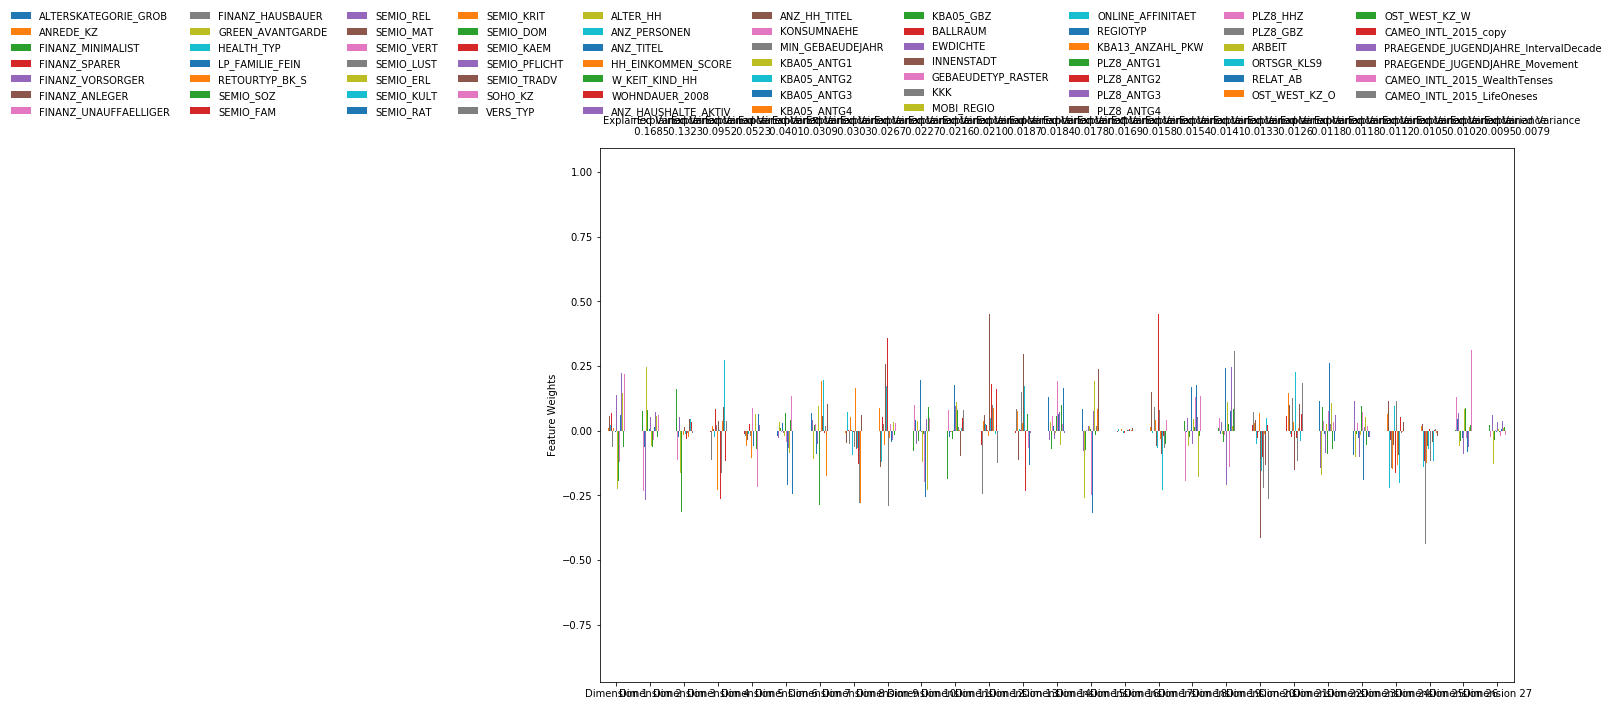

In [96]:
# Investigate the variance accounted for by each principal component.
print('The Explained variance by each PC is: ')
print(pca.explained_variance_ratio_)
print('This is cumulative sum of PCs: ')
print(pca.explained_variance_ratio_.cumsum())

def pca_results(full_dataset, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (14,8))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)
	ax.legend(loc="lower right", frameon=False, borderaxespad=0, ncol=10, bbox_to_anchor=(1.1, 1.05))
	plt.tight_layout()

	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

pca_results(ss_Imputed_BelowThresholdMissing_df, pca)

In [97]:
# The position of pca at which the total variance crosses 80%
print('The number of principal components required to define more than 80% variance is: ',
      np.where(pca.explained_variance_ratio_.cumsum() > 0.8)[0][0])

The number of principal components required to define more than 80% variance is:  21


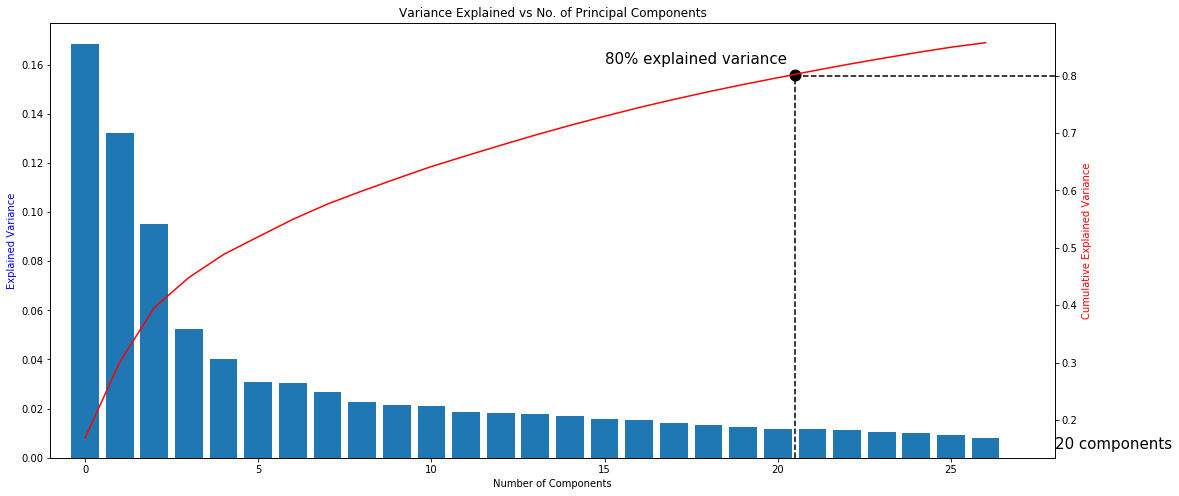

In [98]:
# Investigate the variance accounted for by each principal component.

components_total = len(pca.explained_variance_ratio_)
components = np.arange(components_total)

fig, ax1 = plt.subplots(figsize=(18,8))

ax1.bar(components,pca.explained_variance_ratio_)
ax1.set_ylabel('Explained Variance', color="blue")
ax1.set_xlabel('Number of Components')
ax1.axvline(20.5, ls="--", color="black", ymax=0.88)
ax1.set_xlim(-1,28)

ax2 = ax1.twinx() 

ax2.plot(pca.explained_variance_ratio_.cumsum(), color="red")
ax2.hlines(y=0.8,xmin=20.5,xmax=30,linestyles='dashed')
ax2.scatter(x = [20.5], y =[0.801], marker="o", linewidth=6.0, color="black")
ax2.text(15,0.82,"80% explained variance", fontsize=15, color="black")
ax2.text(28,0.15,"20 components", fontsize=15, color="black")
ax2.set_ylabel('Cumulative Explained Variance', color="red")
plt.title("Variance Explained vs No. of Principal Components")

# saving height of bars to collect individual component %
component_perct = []

for i in ax1.patches:
    component_perct.append(i.get_height())

In [99]:
# Re-apply PCA to the data while selecting for number of components to retain.

# Reffiting for 22 components of pca
pca_22 = PCA(n_components=22)
BelowThresholdMissing_df_pca_22 = pca_22.fit_transform(ss_Imputed_BelowThresholdMissing_df)

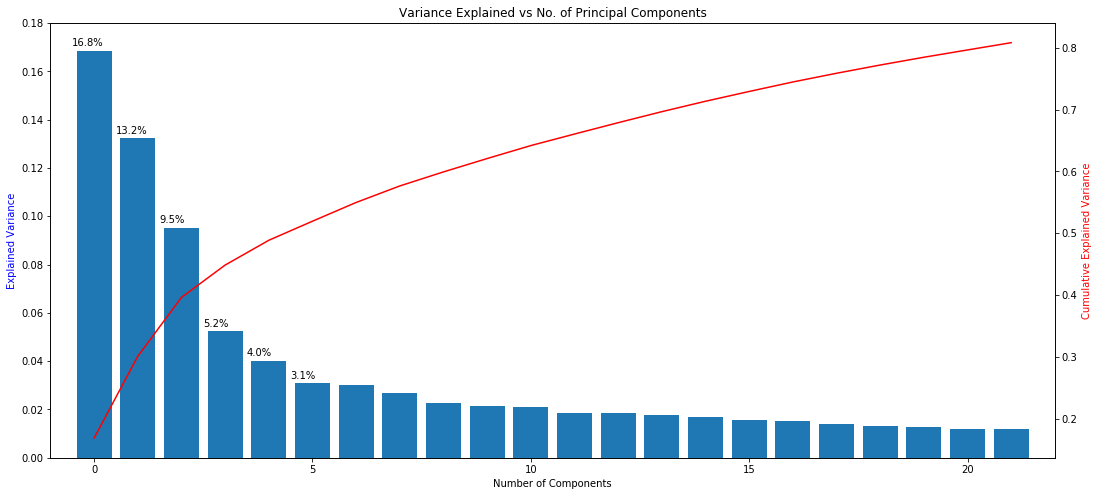

In [100]:
# Investigate the variance accounted for by each principal component.

components_total = len(pca_22.explained_variance_ratio_)
components = np.arange(components_total)

fig, ax1 = plt.subplots(figsize=(18,8))

ax1.bar(components,pca_22.explained_variance_ratio_)
ax1.set_ylabel('Explained Variance', color="blue")
ax1.set_xlabel('Number of Components')

ax2 = ax1.twinx() 

ax1.set_xlim(-1,22)
ax1.set_ylim(0,0.18)

ax2.plot(np.cumsum(pca_22.explained_variance_ratio_), color="red")
ax2.set_ylabel('Cumulative Explained Variance', color="red")
plt.title("Variance Explained vs No. of Principal Components")

# annotate first 6 principle components with % values
for i,j in zip(ax1.patches[0:6],component_perct[0:6]):
    ax1.text(i.get_x()-.1, j+0.002,\
    str(round((j)*100, 1))+'%', fontsize=10)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

**Answer**

The above two graphs clears our understanding that more than 80% variance is captured by 21 principal components and hence we can now proceed to re-fit PCA by using 21 components. Note that the counting on array is from index 0 but pca counts from 1, hence the component in pca is 22 and in array index it is 21. Therefore we shall select first 22 components as n_components in pca.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [101]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def plot_features(scaled_df, pca, component_perct, pc_num, tb_n=10):
    pca_df = pd.DataFrame(pca.components_,columns=scaled_df.columns,\
                 index = [f"PC-{i}" for i in range(1,len(pca.components_
                                                        )+1)])

    sorted_df = pca_df.iloc[pc_num-1:pc_num,:].\
                sort_values(f"PC-{pc_num}", axis=1, ascending=True,inplace=False, kind='quicksort')    

    sorted_df.plot.bar(figsize=(14,6), legend=False)
    plt.ylabel('Feature Weights', fontsize=12)
    plt.xlabel('Principle Component', fontsize=12)
    plt.title(f'Explained Variance: {round(component_perct[pc_num-1]*100,1)}%', fontsize=12)
    highest_n = sorted_df.iloc[:,0:tb_n]
    lowest_n = sorted_df.iloc[:, -tb_n:]
    sorted_top_n = pd.concat([highest_n,lowest_n], axis=1)

    sorted_top_n.plot.bar(figsize=(14,6))
    plt.ylabel('Feature Weights', fontsize=12)
    plt.xlabel('Principle Component', fontsize=12)
    plt.title(f'Top and Bottom {tb_n} Features', fontsize=12)


def features_sorted(scaled_df, pca, pc_num=1):
    azdias_pca_df = pd.DataFrame(pca.components_,columns=scaled_df.columns,\
                 index = [f"PC-{i}" for i in range(1,len(pca.components_)+1)])

    sorted_df = azdias_pca_df.iloc[pc_num-1:pc_num,:].\
                sort_values(f"PC-{pc_num}", axis=1, ascending=True,inplace=False, kind='quicksort')  
        
    sorted_features = list(sorted_df.columns)
    print(f"Strongest +ve feature: {sorted_features[-1]},\nStrongest -ve feature: {sorted_features[0]}")
    return sorted_features

Strongest +ve feature: PLZ8_ANTG3,
Strongest -ve feature: KBA05_ANTG1


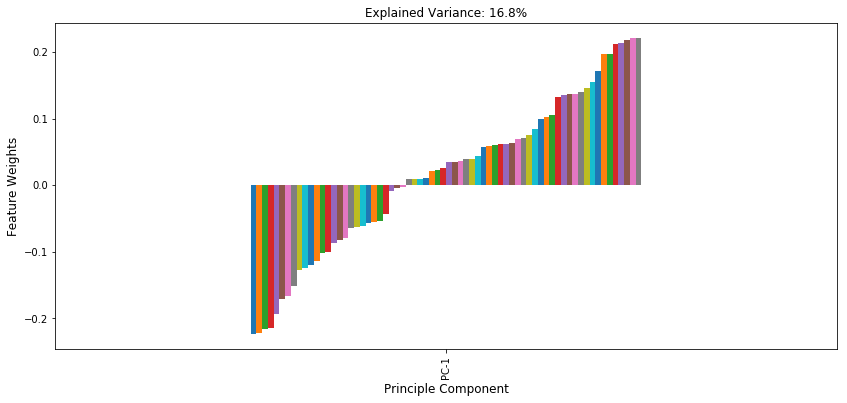

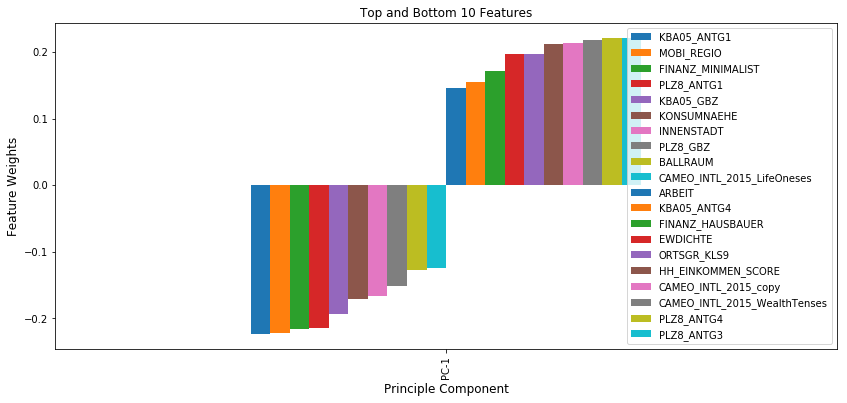

In [102]:
plot_features(ss_Imputed_BelowThresholdMissing_df, pca,component_perct, pc_num=1, tb_n=10)
feats_pc1 = features_sorted(ss_Imputed_BelowThresholdMissing_df, pca_22, pc_num=1)

Strongest +ve feature: ALTERSKATEGORIE_GROB,
Strongest -ve feature: SEMIO_REL


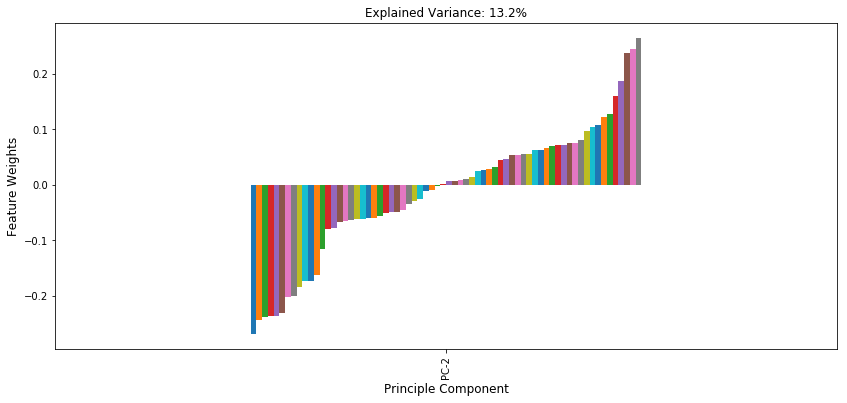

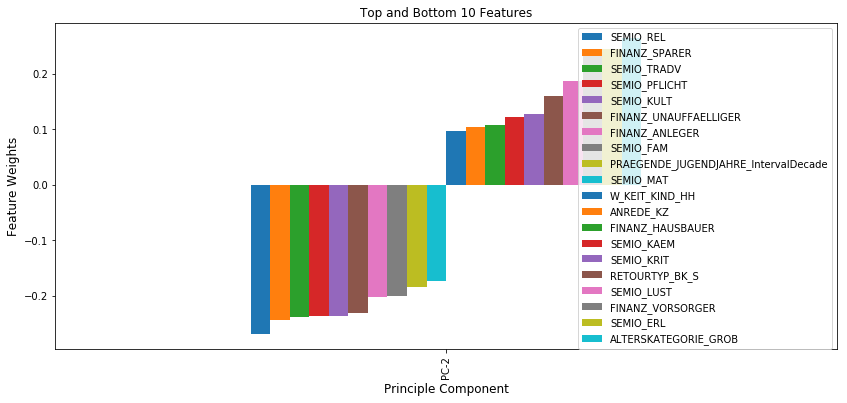

In [103]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_features(ss_Imputed_BelowThresholdMissing_df, pca,component_perct, pc_num=2, tb_n=10)
feats_pc2 = features_sorted(ss_Imputed_BelowThresholdMissing_df, pca_22, pc_num=2)

Strongest +ve feature: SEMIO_VERT,
Strongest -ve feature: ANREDE_KZ


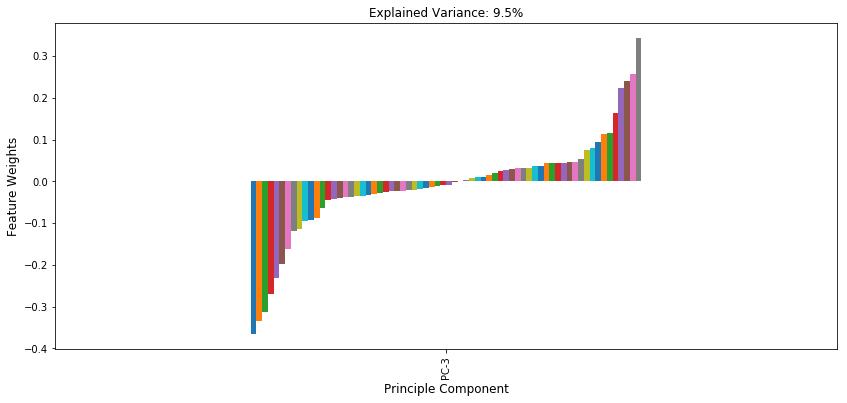

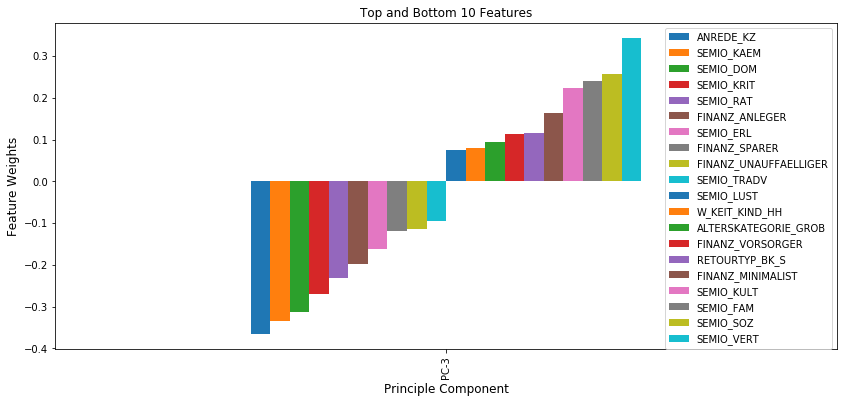

In [104]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_features(ss_Imputed_BelowThresholdMissing_df, pca,component_perct, pc_num=3, tb_n=10)
feats_pc2 = features_sorted(ss_Imputed_BelowThresholdMissing_df, pca_22, pc_num=3)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

**Answer**

**1st principal component**:

*Strongest positive components are;* 

1.) PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region

2.) PLZ8ANTG4: Number of 10+ family houses in the PLZ8 region

The reason that these 2 positively correlate can be due to large families in these areas which contribute to higher population density. Both variables suggest that the the areas have comparatively larger families per household and hence this could be a reason that both go hand in hand about this information in PC1.

*Strongest negative components are;*

1.) KBA05_ANTG1: Number of 1-2 family houses in the microcell

2.) MOBI_REGIO: Movement patterns 

The strongest two negative variables are less correlated for obvious reasons. One of the levels within MOBI_REGIO, i.e. "very high movement" corresponds to someone living in a remote area with less population density. These levels of individuals will need to travel a lot (i.e. commute). Hence, we can infer from this that why somewhere the fewer family houses is correlated with a certain type of movement patterns.


**2nd principal component**:

*Strongest positive components are;*

1.) ALTERSKATEGORIE_GROB: Estimated age based on given name analysis 

2.) SEMIO_ERL: Personality typology, Event Oriented

It makes sense to see that age estimation and personality trait goes in correlation. We have age base of young popuation and middle age population as well and these individuals are likely to be concerned about events and importance or their interests associated with it. Hence it is very likely that people with their inclination to particular events can associate themselves with it and for a particular cabal.

*Strongest negative components are;*

1.) SEMIO_REL: Personality topology, Relegious

2.) FINANZ_SPARER: Financial typology, SPARER - Money Saver

Relegious people tend to spend money for relegious cause such as functions, rituals and relegious charities like spending on missionaries and conversions. Hence it is very likely that these type of people may not be extravagant when it comes to spending on comfort, fasion, charities for social causes like diseases or helping irrespective of ones relegion. Thus such people will save money when it comes to something not involving relegion or is against their relegion. Hence this may be one of the reasons why there two variables are negatively correlated.


**3rd Principal Component**:

*Strongest positive Components are;*

1.) SEMIO_VERT: Personality typology, VERT - dreamful 

2.) SEMIO_SOZ: Personality typology, socially - minded

Both the components here which are positively correlated seem to be about people who think very meticulously about the world. But it is possible that both can think in very opposite direction such as one might be of thinking 'Alice in Wonderland' and other might be a person with practical thinking and observing future of nation based on his analysis of numbers, news and reports. Its tough to say anything conclusively here but for a broader sense we can say that both the people are very much social creature and tend for better world which is peaceful or atleast a world that they want or desire it to be which may or may not be peaceful.

*Strongest negative components are;*

1.) ANREDE_KZ: Gender 

2.) SEMIO_KAEM: Personality typology, KAEM - combative attitude 

The strongest negative features include gender and and a combative attitude. It is possible that, due to higher levels of testosterone, there is a higher proportion of males that have a combative attitude compared to females, which is causing the positive correlation between these features.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [105]:
# Creating dataframe from PCA output
azdias_clean_scld_pca_df = pd.DataFrame(BelowThresholdMissing_df_pca_22, \
                                     columns = [f"PC-{i}" for i in range(1,len(pca_22.components_)+1)])

In [106]:

# Over a number of different cluster counts...

    # run k-means clustering on the data and...

from sklearn.cluster import KMeans
def elbow(num_km, data):
    
    num_clusters = []
    sse = []
    
    for i in range(2,num_km+1):
        kmeans = KMeans(n_clusters=i, init='k-means++',  max_iter=500)
        kmeans_fit = kmeans.fit(data) 
        sse_val = kmeans_fit.inertia_
        
        sse.append(sse_val)
        num_clusters.append(i)
        
    return sse, num_clusters

# compute the average within-cluster distances.
sse3, num_k3 = elbow(15, azdias_clean_scld_pca_df)


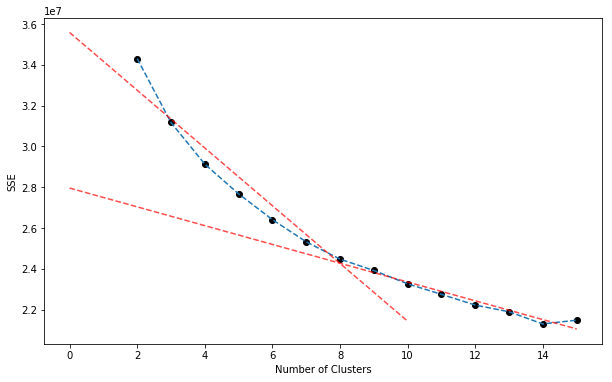

In [107]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

bf_line = [0]+num_k3[-10:]
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(num_k3,sse3, color="black")
ax.plot(num_k3,sse3,'--')
ax.plot(bf_line, np.poly1d(np.polyfit(num_k3[-8:], sse3[-8:], 1))(bf_line),'--', color='red', alpha=0.7)
ax.plot([0,2,3,4,6,8,10], np.poly1d(np.polyfit(num_k3[0:8], sse3[0:8],1))([0,2,3,4,6,8,10]),'--', color='red', alpha=0.7)
ax.set_ylabel('SSE')
ax.set_xlabel('Number of Clusters')
plt.show()
#ax.xaxis.set(ticks=range(1,num_k3[-1]+2))
#ax.annotate('elbow', xy=(0.1, 0.1), xytext=(1,1),arrowprops=dict(facecolor='black', shrink=0.1),fontsize=5, clip_on = True)
#plt.title("SSE Vs No. of Clusters")
#plt.show()

In [108]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=8, init='k-means++',  max_iter=300)
kmeans_fit = kmeans.fit(azdias_clean_scld_pca_df)

# Attaching predictions to datafrae
azdias_clean_scld_pca_df["labels"] = kmeans_fit.labels_
azdias_clean_scld_pca_df.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,...,PC-14,PC-15,PC-16,PC-17,PC-18,PC-19,PC-20,PC-21,PC-22,labels
0,3.757693,-2.572206,-2.981613,-0.668527,-1.395177,1.998173,2.346736,-0.775554,0.350442,-0.141647,...,-1.436937,-2.180408,10.889559,-0.441300,-0.334410,0.852052,1.385979,-0.051845,-0.783119,2
1,-1.023076,0.597232,-3.018750,1.837306,-0.731189,0.297258,-1.429745,-0.837323,-0.824141,0.733843,...,0.535202,-1.327689,-0.183152,0.643563,-0.943860,-1.952859,0.006873,0.460230,-0.013156,1
2,-4.041521,1.513711,-0.670604,-0.558154,-0.382743,0.344602,-0.777923,0.912968,-0.592361,-0.149218,...,-0.102631,0.368009,-0.043768,0.593599,-0.143041,1.407666,-0.325934,-0.764219,0.513121,1
3,0.417760,-0.066131,3.238961,1.266562,0.685898,-3.678955,2.489558,0.309619,-0.514944,-0.595187,...,-0.333175,0.074012,-0.156827,-0.994888,-0.593982,-0.873811,-0.143760,1.573749,-0.109839,3
4,-0.322715,-1.293857,-1.128790,-2.038099,-3.013550,0.100735,-0.969797,-0.664172,3.454197,-1.859878,...,-1.458903,-0.791142,-0.048404,-0.208608,1.854552,0.455143,-1.093463,0.570666,-1.099548,0


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

**Answers**

Multiple KMeans models have been fitted through a range of different values for the number of clusters. The sum of the squared errors (SSE) value was obtained though the "inertia_" attribute. This calculates the SSEs for the cluster center and the surrounding points. By plotting this versus the cluster size, it should become apparent the point at which additional clusters have a decreased benefit - visible from the so called "elbow" appearance of the graph.

In the plot above, the elbow is not the most distinct, but there is a clear shift in the rate at which SSE decreases in the range of 2 to 10 clusters. As each additional cluster provides a decreased benefit, I have decided to pick a number in the middle of the range and use 8 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [109]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
print(customers.shape)
customers.head()

(191652, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [110]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_preprocessed = clean_data(customers, 25)
customers_preprocessed.shape

dataframe name df_copy from original dataframe has been generated for upcoming manipulations 

Columns with greater than 40% missing values have been dropped 

multi-level categorical variables have been dropped 

apart from mentioned 2, other mixed variables have been dropped 

Observing the shape of cleaned dataframe  (141709, 68) and the cleaned azdias dataframe shape is  (797981, 68)


(141709, 68)

In [111]:
# Carry out impuation 
customers_preprocessed_impd_arr = fill_NaN.transform(customers_preprocessed)

# Converting from array back to dataframe
customers_preprocessed_impd = pd.DataFrame(customers_preprocessed_impd_arr, columns = customers_preprocessed.columns)

# Transform dataset using trained StandardScaler
customers_preprocessed_impd_scld_arr = scaler.transform(customers_preprocessed_impd)
# Converting from array back to dataframe
customers_preprocessed_impd_scld = pd.DataFrame(customers_preprocessed_impd_scld_arr, columns = customers_preprocessed.columns,\
                                                index = customers_preprocessed.index)

customers_preprocessed_impd_scld.head(n=1)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,CAMEO_INTL_2015_copy,PRAEGENDE_JUGENDJAHRE_IntervalDecade,PRAEGENDE_JUGENDJAHRE_Movement,CAMEO_INTL_2015_WealthTenses,CAMEO_INTL_2015_LifeOneses
0,1.179063,-1.043905,1.409051,-1.155491,1.138139,-1.249968,-0.470319,-0.791295,1.885243,-1.262634,...,-2.102446,-1.402623,-1.494262,-0.517431,0.517431,-1.552192,-1.0457,-1.706778,-1.504991,0.099358


In [112]:
# Applying PCA
customer_pca_22 = pca_22.transform(customers_preprocessed_impd_scld)

# Creating dataframe from PCA output
cust_clean_scld_pca_df = pd.DataFrame(customer_pca_22, \
                                      columns = [f"PC-{i}" for i in range(1,len(pca_22.components_)+1)])

# Applying previously trained KMeans model to get predicted labels on customer data
###cust_clean_scld_pca_df["labels"] = kmeans.predict(cust_clean_scld_pca_df)

customer_predictions = kmeans.predict(cust_clean_scld_pca_df)

cust_clean_scld_pca_df.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,...,PC-13,PC-14,PC-15,PC-16,PC-17,PC-18,PC-19,PC-20,PC-21,PC-22
0,-5.819612,0.807582,4.213202,1.633979,-1.888192,1.714077,-0.758410,-2.089436,0.129701,1.276459,...,-0.258552,0.823810,0.100614,-0.162127,0.811716,0.191815,-0.979989,-0.049966,0.795129,0.330956
1,-1.402664,4.913347,-0.507898,2.356168,-0.271187,-0.476734,-1.449413,0.791219,-0.523485,1.079079,...,-1.129079,-0.476184,0.227954,-0.055692,1.666862,0.112001,1.045667,-1.730277,0.132525,-1.519845
2,-4.230396,0.281299,2.694560,-2.157706,-1.471814,1.234148,-0.106678,0.747419,0.813196,0.287409,...,-0.224203,-0.444195,0.540502,-0.044425,0.338357,0.655216,1.201957,-0.650629,-0.637554,0.864189
3,1.241211,-1.184029,1.090344,0.245264,-0.470048,-2.203900,3.089198,-0.333767,0.549033,1.170005,...,0.929463,-1.300548,1.659634,-0.116650,0.811641,0.026666,-0.785343,-0.637895,-0.142430,-0.231151
4,-2.251435,1.198948,2.837161,2.502439,-1.304677,-0.281467,-0.636940,-1.929480,-0.066318,-0.731976,...,-0.810525,-1.290455,-2.268958,-0.033914,-0.469775,0.375215,1.162233,-0.769696,-0.449395,-0.467509


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [113]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Using total number of entries in each dataset
# to normalise cluster proportions
pop_total_entries = azdias.shape[0]
cust_total_entries = customers.shape[0]

# Percentage of population clusters
population_label_counts  = list(azdias_clean_scld_pca_df["labels"].value_counts()/pop_total_entries*100)

# Population cluster No.
# Adjusted by +0.8 so as to start numbering 
# at 1 then move population bars to the left
pop_labels = list(azdias_clean_scld_pca_df["labels"].value_counts().index+0.85)


# Grouping labels and counts for customers
customer_labels_dict = Counter(customer_predictions)
customer_labels = list(customer_labels_dict.keys())
# Adding 1.15 to start clusters (labels) at 1 and
# to adjusting bar position on plot 
customer_labels_adj = [i + 1.15 for i in customer_labels]

# Percentage of population clusters
customer_label_counts = list(customer_labels_dict.values())
cust_label_perc = [(j/cust_total_entries*100) for j in customer_label_counts]

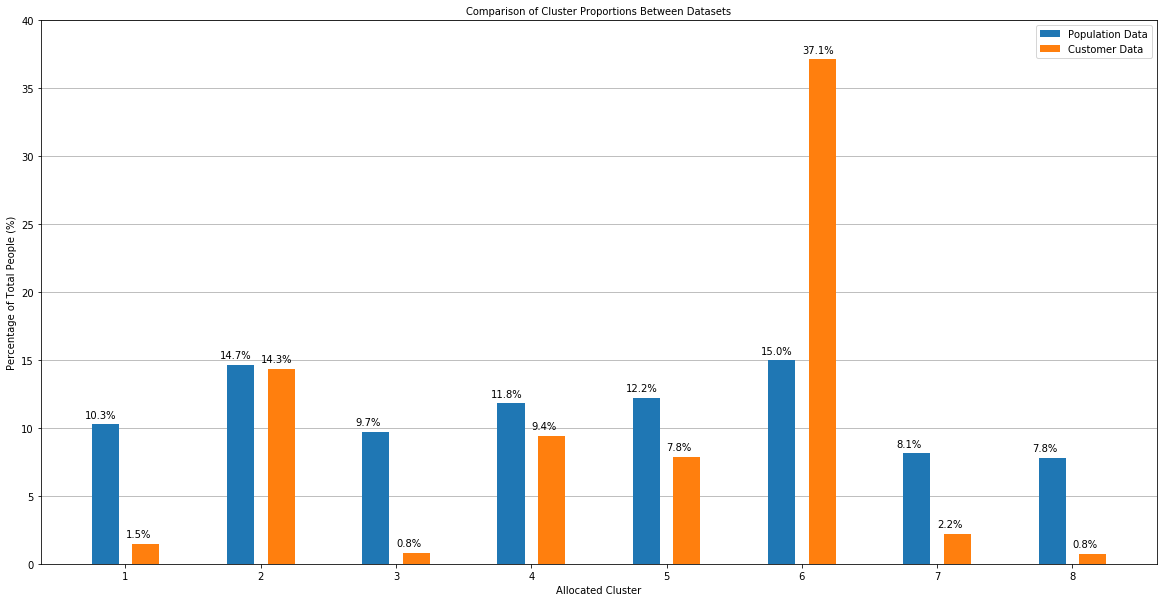

In [114]:
# Plotting clusters for population and customer datasets
fig, ax = plt.subplots(figsize = (20,10))

ax.bar(pop_labels,population_label_counts,width = 0.2,label='Population Data', zorder=3)
###ax.bar(cust_label_counts,customer_labels, width = 0.25, label='Customer Data', zorder=3)
ax.bar(customer_labels_adj,cust_label_perc, width = 0.2, label='Customer Data', zorder=3)


ax.yaxis.grid(zorder=0)
ax.set_ylim(0,40)
ax.set_ylabel('Percentage of Total People (%)', fontsize = 10)

ax.xaxis.set(ticks=range(1,9))
ax.set_xlabel('Allocated Cluster', fontsize = 10)

plt.title('Comparison of Cluster Proportions Between Datasets', fontsize = 10)
plt.legend(loc='best', fontsize=10)

# Collecting percentage data
component_perct_2 = []
for i in ax.patches:
    component_perct_2.append(i.get_height())

for i,j in zip(ax.patches,component_perct_2):
    ax.text(i.get_x()-.05, j+.5, str(round((j), 1))+'%', fontsize=10)

    
plt.show()

       PC-2      PC-1      PC-7     PC-13     PC-10     PC-11     PC-14  \
0 -2.637537 -1.039204 -0.289773 -0.010315  0.052448 -0.135117  0.112399   
1  1.897289 -3.317881  0.000111 -0.113587 -0.016839  0.068167 -0.010733   
2 -1.152787  4.255949 -0.138248 -0.163296  0.046864 -0.071711  0.162088   

      PC-18     PC-19     PC-16    ...        PC-17     PC-12      PC-5  \
0 -0.097531  0.000450 -0.005644    ...    -0.017068 -0.005128 -0.084273   
1  0.097748  0.026622  0.001373    ...     0.045568  0.011287  0.255798   
2  0.159650  0.070655  0.000096    ...     0.080590 -0.050076  0.000102   

       PC-6      PC-9     PC-22     PC-15      PC-8      PC-4      PC-3  
0  0.199083  0.399109 -0.053854  0.102437  0.021399 -0.039127 -3.177068  
1  0.032335 -0.159149  0.028274  0.028911  0.032593  0.226537 -1.749545  
2 -0.027337  0.469669  0.006269  0.018479  0.055083  0.313052 -2.612004  

[3 rows x 22 columns]


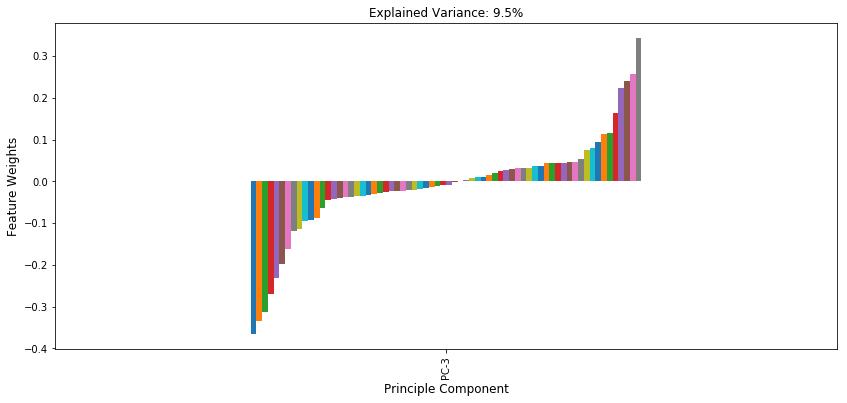

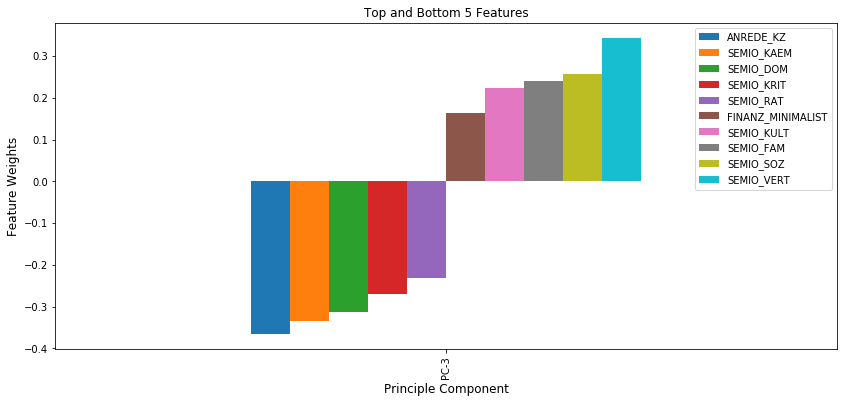

In [115]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Obtaining cluster centroids and related PC strengths
centroids_pcs = kmeans.cluster_centers_
centroids_pcs_df = pd.DataFrame(centroids_pcs, columns = cust_clean_scld_pca_df.columns)

# Cluster 3  (index = 2) is over-represented as seen from bar plot
# Finding strongly associated PCs for this cluster:
print(centroids_pcs_df.loc[0:5,:].sort_values(by = 4,axis=1, ascending = False).head(n=3))

# Investgating related features to 3rd principal component ("PC-4")
plot_features(customers_preprocessed, pca_22,component_perct, pc_num=3, tb_n=5)

In [116]:
# Calculating mean wealth
print('Mean of SEMIO_VERT from customers dataset is: ', customers_preprocessed['SEMIO_VERT'].mean())
print('Mean of SEMIO_VERT from azdias dataset is: ', ss_Imputed_BelowThresholdMissing_df['SEMIO_VERT'].mean())

print('\nMean of ANREDE_KZ from customers dataset is: ', customers_preprocessed['ANREDE_KZ'].mean())
print('Mean of ANREDE_KZ from azdias dataset is: ', ss_Imputed_BelowThresholdMissing_df['ANREDE_KZ'].mean())

print('\nShape of customers dataset is : ', customers_preprocessed.shape)
print('Shape of azdias dataset is: ', ss_Imputed_BelowThresholdMissing_df.shape)

Mean of SEMIO_VERT from customers dataset is:  5.19415139476
Mean of SEMIO_VERT from azdias dataset is:  6.22763686592e-17

Mean of ANREDE_KZ from customers dataset is:  1.33072705333
Mean of ANREDE_KZ from azdias dataset is:  -1.62422539421e-16

Shape of customers dataset is :  (141709, 68)
Shape of azdias dataset is:  (797981, 68)


In [117]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Cluster 2 (index = 1) is under-represented as seen from bar plot
# Finding strongly associated PCs for this cluster:
centroids_pcs_df.loc[0:2,:].sort_values(by = 1,axis=1, ascending = False).head(n=1)

,PC-2,PC-5,PC-4,PC-18,PC-11,PC-17,PC-8,PC-6,PC-15,PC-22,...,PC-16,PC-7,PC-14,PC-10,PC-20,PC-21,PC-13,PC-9,PC-3,PC-1
0,-2.637537,-0.084273,-0.039127,-0.097531,-0.135117,-0.017068,0.021399,0.199083,0.102437,-0.053854,...,-0.005644,-0.289773,0.112399,0.052448,-0.001762,0.095842,-0.010315,0.399109,-3.177068,-1.039204


The 1st principal component seems to have strongest association with the 4th cluster

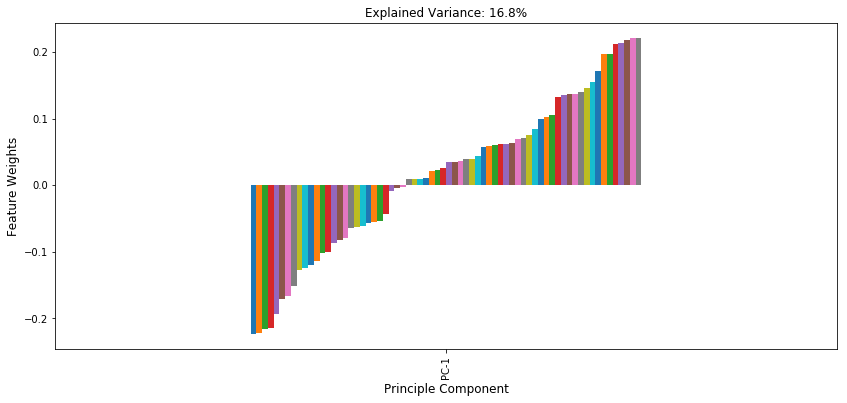

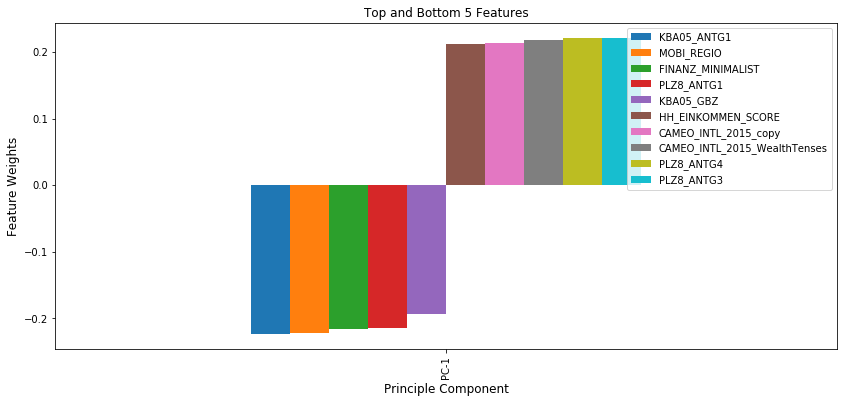

In [118]:
# Investgating related features to 1st principal component ("PC-1")
plot_features(customers_preprocessed, pca_22,component_perct, pc_num=1, tb_n=5)

In [119]:
# Calculating mean of KBA05_ANTG1
print('The mean value from customers dataset for KBA05_ANTG1: ',customers_preprocessed['KBA05_ANTG1'].mean())
print('The mean value from azdias dataset for KBA05_ANTG1: ',ss_Imputed_BelowThresholdMissing_df['KBA05_ANTG1'].mean())

# Calculating mean value for PLZ8_ANTG3
print('\nThe mean value from customers dataset for PLZ8_ANTG3: ',customers_preprocessed['PLZ8_ANTG3'].mean()/141709)
print('The mean value from azdias dataset for PLZ8_ANTG3: ',ss_Imputed_BelowThresholdMissing_df['PLZ8_ANTG3'].mean()/797384)    

The mean value from customers dataset for KBA05_ANTG1:  2.20705819919
The mean value from azdias dataset for KBA05_ANTG1:  0.0533615701828

The mean value from customers dataset for PLZ8_ANTG3:  9.80048471465e-06
The mean value from azdias dataset for PLZ8_ANTG3:  5.78597378676e-08


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Following cluster analysis, there appears to be a few noticeable difference between the clustering of the two demographics. To make inferences about the people type related to the clusters, the centroids were mapped back to the corresponding principal (PC) components. These were then ranked in descending order so the the PC with the strongest association could be chosen. The features corresponding to this PC could then be found by using the previous mapping of PCs to features. It is worth noting that the values for explained variance are for the previous mapping and are not accurate for the customer data.

**Over-representation:**

After observing a significant amount of over-representation (approx. 37%) for the number 5 labeled cluster, the following two features were found to have the strongest association:

*SEMIO_VERT*: This is a feature which says about personality and here it tells us that individual is 'dreamful'.

*ANREDE_KZ*: This variable tells about the gender.

Here the First feature about person being "dreamful" can be valid as the company is mail order and relies on people buying goods. Therefore, a person who day dreams we can assume for this particular variable interpretation will tend to not move from one place and would prefer things to come towards him and thus engage in placing orders by dreaming and thinking and then it may lead to desire to posses some thing which passes his or her mind. The mean in both the general population and customer dataset is high and hence it could be a genuinely important variable.

The Second variable tells us about the gender. Here it is difficult interpret why a gender would make anyone averse or incline in buying from mail-sales order company. But the general population data also has this feature negatively correlated and therefore it might be one of the variable that is important and would require detailed investigation and more data attached to it.

**Under-representation:**

*KBA05_ANTG1*: Number of 1-2 family houses in the microcell

*PLZ8_ANTG3*: Number of 6-10 family houses in the PLZ8 region


Here we can say that this density of population according to region and per family can be related to the usage of mail order service. Example could be that the individuals having nuclear families tend to have better financial conditions and would strive for flourishments and thereby prefer mail-order services because either they can affor or would not mind spending money on it.

The negatively correlated variable shows higher individuals in family and thus such individuals would probably prefer spending time together or atleast have company of each other and would go out to buy together and this can be one of the reasons that they dont prefer much mail-order services. Other perception can be that the people having larger family size tend to come from poor families with mindset of more hands to work shall lead to more earnings to household. Thus they may not afford such services and probably wont go for it.

Both the above variables were also displayed as important while analyzing general population data which is shown in PC1 of general population.

**Conclusion**

Personally I shall say that we need more roboust data with less missing values. Different algorithms can also help to fit the data and see how consistent the insights or importance of variables are across all of them. I would also suggest a ground campaign to verify and validate our important variables weightage with feedback from people and observing society in general. Meticulously going through case studies on similar topics especially of such scenarios in different geographys as well as competitors can also help

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.